#Регрессия

##Базовая модель

Реализуем базовую модель случайного леса RandomForestRegressor из библиотеки sklearn на простом наборе признаков. В качестве признаков используются агрегаты по чеку:
• TotalQuantity (общее количество купленных товаров),
• NumLines (число строк в чеке),
• MeanPrice (средняя цена товара в чеке).
Целевая переменная ‒ TotalCheck (общая сумма чека).
Эта модель служит отправной точкой для оценки качества случайного леса на минимальном, «простом» представлении данных без дополнительных признаков и сложного препроцессинга.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

DATA_DIR = Path("/content/drive/MyDrive/Учеба/Фреймворки/data")
SIMPLE_REG_PATH = DATA_DIR / "regression_data_simple.csv"
HARD_REG_PATH = DATA_DIR / "regression_data_hard.csv"

reg_simple = pd.read_csv(SIMPLE_REG_PATH)

feature_cols_simple = ["TotalQuantity", "NumLines", "MeanPrice"]
target_col = "TotalCheck"

X_simple = reg_simple[feature_cols_simple].values
y_simple = reg_simple[target_col].values

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_simple,
    y_simple,
    test_size=0.2,
    random_state=42,
)

print("Simple regression dataset shape:", reg_simple.shape)
print("Baseline X shape:", X_simple.shape)
print("Baseline y shape:", y_simple.shape)
print("Baseline train size:", X_train_s.shape[0])
print("Baseline test size:", X_test_s.shape[0])

rf_sklearn_simple = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=8,
    min_samples_split=50,
    min_samples_leaf=20,
    n_jobs=-1,
)

rf_sklearn_simple.fit(X_train_s, y_train_s)
y_pred_rf_simple = rf_sklearn_simple.predict(X_test_s)

mae_rf_s = mean_absolute_error(y_test_s, y_pred_rf_simple)
rmse_rf_s = np.sqrt(mean_squared_error(y_test_s, y_pred_rf_simple))
r2_rf_s = r2_score(y_test_s, y_pred_rf_simple)

print("\n=== 1) Sklearn RandomForestRegressor (simple baseline) ===")
print(f"MAE:  {mae_rf_s:.2f}")
print(f"RMSE: {rmse_rf_s:.2f}")
print(f"R²:   {r2_rf_s:.4f}")


Simple regression dataset shape: (39574, 6)
Baseline X shape: (39574, 3)
Baseline y shape: (39574,)
Baseline train size: 31659
Baseline test size: 7915

=== 1) Sklearn RandomForestRegressor (simple baseline) ===
MAE:  117.04
RMSE: 486.28
R²:   0.7612


Для базового набора признаков (TotalQuantity, NumLines, MeanPrice) модель RandomForestRegressor с параметрами
n_estimators=100, random_state=42 показала на тестовой выборке качество MAE ≈ 117.0, RMSE ≈ 486.3, R² ≈ 0.761.

В качестве следующего шага настроим гиперпараметры модели: вместо базовой конфигурации
n_estimators=100, random_state=42, max_depth=8, min_samples_split=50, min_samples_leaf=20, n_jobs=-1
рассмотрим более «свободные» настройки:
n_estimators=100, max_depth=16, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=42,
чтобы проверить, как снятие жёстких ограничений по глубине и размерам узлов повлияет на качество предсказаний.

In [ ]:
rf_sklearn_simple = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=16,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
)

rf_sklearn_simple.fit(X_train_s, y_train_s)
y_pred_rf_simple = rf_sklearn_simple.predict(X_test_s)

mae_rf_s = mean_absolute_error(y_test_s, y_pred_rf_simple)
rmse_rf_s = np.sqrt(mean_squared_error(y_test_s, y_pred_rf_simple))
r2_rf_s = r2_score(y_test_s, y_pred_rf_simple)

print("\n=== 1) Sklearn RandomForestRegressor (simple baseline) ===")
print(f"MAE:  {mae_rf_s:.2f}")
print(f"RMSE: {rmse_rf_s:.2f}")
print(f"R²:   {r2_rf_s:.4f}")


=== 1) Sklearn RandomForestRegressor (simple baseline) ===
MAE:  91.97
RMSE: 300.37
R²:   0.9089


При использовании случайного леса на базовом наборе признаков (TotalQuantity, NumLines, MeanPrice) изменение гиперпараметров с консервативных значений
max_depth=8, min_samples_split=50, min_samples_leaf=20
на более «свободную» конфигурацию
max_depth=16, min_samples_split=2, min_samples_leaf=1
привело к заметному росту качества модели: MAE снизился c ≈117 до ≈92, RMSE — с ≈486 до ≈300, а R² увеличился с ≈0.76 до ≈0.91. Это означает, что более глубокие и менее жёстко ограниченные деревья лучше описывают нелинейные зависимости между простыми агрегированными признаками и суммой чека, при этом качество на тестовой выборке не деградирует, а существенно растёт.

##Улучшенная модель

Реализуем модель случайного леса RandomForestRegressor на улучшенном наборе признаков. Используется датасет с:
• агрегатами корзины (TotalQuantity, NumLines, NumUniqueItems, MeanPrice),
• временными признаками (InvoiceHour, InvoiceDayOfWeek, InvoiceMonth),
• флагом IsNewCustomer,
• товарными признаками формата qty_<…> для наиболее популярных позиций,
• признаком Country.
Целевая переменная TotalCheck предварительно усечена по 99.5-му перцентилю для снижения влияния аномально больших чеков. Числовые признаки масштабируются с помощью StandardScaler, признак Country кодируется через One-Hot Encoding. Модель позволяет оценить, насколько расширенный и очищенный призначный набор улучшает качество случайного леса по сравнению с базовым вариантом.

In [ ]:

reg_imp = pd.read_csv(HARD_REG_PATH)

q_high = reg_imp[target_col].quantile(0.995)
mask = reg_imp[target_col] <= q_high
reg_trim = reg_imp[mask].reset_index(drop=True)

print("\nImproved regression dataset shape:", reg_imp.shape)
print("Trimmed rows:", len(reg_trim))
print("Cutoff (99.5% quantile) TotalCheck:", q_high)

exclude_cols = ["Invoice", "CustomerID", "InvoiceDate", target_col]
feature_cols_imp = [c for c in reg_trim.columns if c not in exclude_cols]

X_imp = reg_trim[feature_cols_imp]
y_imp = reg_trim[target_col].values

numeric_features = [c for c in feature_cols_imp if c != "Country"]
categorical_features = ["Country"] if "Country" in feature_cols_imp else []

transformers = []
if numeric_features:
    transformers.append(("num", StandardScaler(), numeric_features))
if categorical_features:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features))

preprocessor = ColumnTransformer(transformers=transformers)

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_imp,
    y_imp,
    test_size=0.2,
    random_state=42,
)

print("\nImproved X shape:", X_imp.shape)
print("Improved y shape:", y_imp.shape)
print("Improved train size:", X_train_i.shape[0])
print("Improved test size:", X_test_i.shape[0])

rf_sklearn_improved = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            max_depth=8,
            min_samples_split=50,
            min_samples_leaf=20,
            n_jobs=-1,
        )),
    ]
)

rf_sklearn_improved.fit(X_train_i, y_train_i)
y_pred_rf_imp = rf_sklearn_improved.predict(X_test_i)

mae_rf_i = mean_absolute_error(y_test_i, y_pred_rf_imp)
rmse_rf_i = np.sqrt(mean_squared_error(y_test_i, y_pred_rf_imp))
r2_rf_i = r2_score(y_test_i, y_pred_rf_imp)

print("\n=== 2) Sklearn RandomForestRegressor (improved baseline, trimmed + scaling + OHE) ===")
print(f"MAE:  {mae_rf_i:.2f}")
print(f"RMSE: {rmse_rf_i:.2f}")
print(f"R²:   {r2_rf_i:.4f}")


Improved regression dataset shape: (39574, 113)
Trimmed rows: 39376
Cutoff (99.5% quantile) TotalCheck: 5739.156000000027

Improved X shape: (39376, 109)
Improved y shape: (39376,)
Improved train size: 31500
Improved test size: 7876

=== 2) Sklearn RandomForestRegressor (improved baseline, trimmed + scaling + OHE) ===
MAE:  86.91
RMSE: 190.50
R²:   0.8831


Переход от простого бейзлайна (модель случайного леса только на агрегированных признаках корзины) к улучшенному варианту датасета с дополнительными признаками, стандартизацией числовых столбцов, one-hot кодированием страны и обрезкой выбросов по TotalCheck привёл к заметному снижению ошибок: MAE уменьшился примерно с 92 до 87, RMSE — с ~300 до ~190, при высоком значении R² ≈ 0.88. Это означает, что более богатое и аккуратно подготовленное описание чека позволяет модели лучше восстанавливать суммарный чек при тех же базовых настройках случайного леса.

Далее имеет смысл, как и для простого бейзлайна, ослабить ограничения по глубине и размерам узлов (max_depth, min_samples_split, min_samples_leaf) и проверить, насколько изменение гиперпараметров улучшит качество модели на улучшенном наборе признаков.

In [ ]:
rf_sklearn_improved = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            max_depth=16,
            min_samples_split=2,
            min_samples_leaf=1,
            n_jobs=-1,
        )),
    ]
)


rf_sklearn_improved.fit(X_train_i, y_train_i)
y_pred_rf_imp = rf_sklearn_improved.predict(X_test_i)

mae_rf_i = mean_absolute_error(y_test_i, y_pred_rf_imp)
rmse_rf_i = np.sqrt(mean_squared_error(y_test_i, y_pred_rf_imp))
r2_rf_i = r2_score(y_test_i, y_pred_rf_imp)

print("\n=== 2) Sklearn RandomForestRegressor (improved baseline, trimmed + scaling + OHE) ===")
print(f"MAE:  {mae_rf_i:.2f}")
print(f"RMSE: {rmse_rf_i:.2f}")
print(f"R²:   {r2_rf_i:.4f}")


=== 2) Sklearn RandomForestRegressor (improved baseline, trimmed + scaling + OHE) ===
MAE:  77.00
RMSE: 186.33
R²:   0.8881


На улучшенном бейзлайне (агрегированные признаки корзины, временные признаки, флаг нового пользователя, one-hot кодирование страны, обрезка выбросов по 99.5-перцентилю и масштабирование числовых признаков) случайный лес с настроенными гиперпараметрами показывает качество MAE ≈ 77, RMSE ≈ 186, R² ≈ 0.89. По сравнению с базовой конфигурацией на тех же данных (MAE ≈ 86.9, RMSE ≈ 190.5, R² ≈ 0.883) настройка глубины деревьев и ограничений на разбиения даёт умеренное, но устойчивое улучшение по всем метрикам. Таким образом, RandomForestRegressor на улучшенном наборе признаков с подобранными параметрами можно считать одним из финальных и наиболее сильных вариантов модели для задачи предсказания суммы чека.

Для повышения интерпретируемости моделей на основе деревьев решений дополнительно проведём анализ важности признаков. Для улучшенной модели Random forest построем столбчатые диаграммы (bar plot) значений feature_importances_, на которых отображены ТОП-20 наиболее значимых признаков.

На графиках по оси X отложено значение важности признака, а по оси Y – его название (агрегированные характеристики корзины, временные признаки, индикатор IsNewCustomer, а также признаки формата qty_* и закодированная страна). По этим диаграммам можно увидеть, какие факторы вносят основной вклад в предсказание общей суммы чека и насколько стабильно одни и те же признаки оказываются важными для разных алгоритмов.

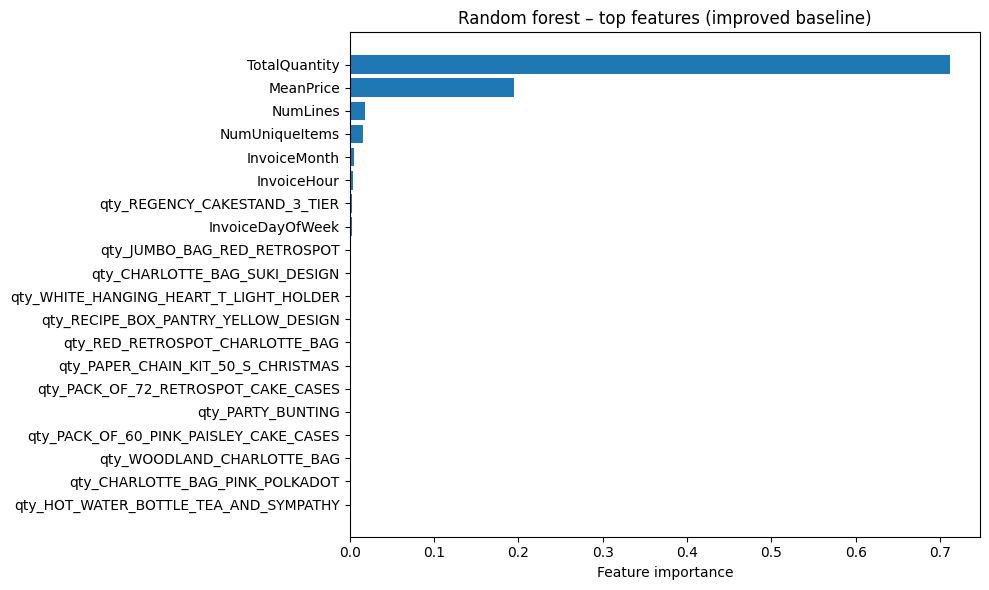

In [12]:
import numpy as np
import matplotlib.pyplot as plt

dt_model = rf_sklearn_improved

preprocessor = dt_model.named_steps["preprocess"]
tree = dt_model.named_steps["model"]

feature_names = []

if "num" in preprocessor.named_transformers_:
    feature_names.extend(numeric_features)

if "cat" in preprocessor.named_transformers_:
    ohe = preprocessor.named_transformers_["cat"]
    cat_names = list(ohe.get_feature_names_out(categorical_features))
    feature_names.extend(cat_names)

importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
top_idx = indices[:top_n]

plt.figure(figsize=(10, 6))
plt.barh(
    np.array(feature_names)[top_idx][::-1],
    importances[top_idx][::-1],
)
plt.xlabel("Feature importance")
plt.title("Random forest – top features (improved baseline)")
plt.tight_layout()
plt.show()


Диаграмма важности признаков для модели Random Forest на улучшенном бейзлайне показывает, что основное влияние на предсказание суммы чека оказывают агрегированные характеристики корзины:

наибольшую важность имеет TotalQuantity (общее количество единиц товара в чеке);

вторым по значимости идёт признак MeanPrice (средняя цена товаров в чеке);

меньший, но заметный вклад вносят NumLines (число строк в чеке) и NumUniqueItems (количество уникальных позиций).

Временные признаки (InvoiceMonth, InvoiceHour, InvoiceDayOfWeek) и отдельные товарные индикаторы формата qty_* имеют существенно меньшую важность. Они используются моделью для уточнения предсказаний в частных случаях, но не определяют общую структуру решения.

Таким образом, случайный лес подтверждает общий вывод: сумма чека в первую очередь определяется размером корзины и уровнем цен, в то время как конкретный состав товаров и время покупки играют вспомогательную роль.

##Имплементирование алгоритма

###Базовая модель

Реализуем и проверим собственную версия алгоритма случайного леса регрессии на простом бейзлайне. Кастомный MyRandomForestRegressor строится как ансамбль нескольких регрессионных деревьев MyDecisionTreeRegressor, каждое из которых обучается на бутстрап-выборке объектов и случайном подмножестве признаков.
В качестве входных признаков используются те же агрегаты по чеку (TotalQuantity, NumLines, MeanPrice), а таргетом остаётся TotalCheck. Полученные результаты позволяют сравнить качество и поведение самописного ансамбля с библиотечной реализацией RandomForestRegressor при одинаковом наборе входных данных.

In [ ]:
class MyDecisionTreeRegressor:
    class Node:
        def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
            self.feature_idx = feature_idx
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def __init__(self, max_depth=8, min_samples_split=50, min_samples_leaf=20):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        self.root_ = self._build_tree(X, y, depth=0)
        return self

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape

        if n_samples == 0:
            return self.Node(value=0.0)

        if depth >= self.max_depth or n_samples < self.min_samples_split or np.allclose(y, y[0]):
            value = float(y.mean())
            return self.Node(value=value)

        best_feature, best_threshold, best_loss = self._find_best_split(X, y)

        if best_feature is None:
            value = float(y.mean())
            return self.Node(value=value)

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]

        if X_left.shape[0] == 0 or X_right.shape[0] == 0:
            value = float(y.mean())
            return self.Node(value=value)

        left_child = self._build_tree(X_left, y_left, depth + 1)
        right_child = self._build_tree(X_right, y_right, depth + 1)

        return self.Node(
            feature_idx=best_feature,
            threshold=best_threshold,
            left=left_child,
            right=right_child,
            value=None,
        )

    def _find_best_split(self, X, y):
        n_samples, n_features = X.shape
        if n_samples < 2 * self.min_samples_leaf:
            return None, None, None

        total_sum = y.sum()
        total_sq_sum = np.dot(y, y)

        best_feature = None
        best_threshold = None
        best_loss = np.inf

        for j in range(n_features):
            xj = X[:, j]
            order = np.argsort(xj)
            xj_sorted = xj[order]
            y_sorted = y[order]

            y_cumsum = np.cumsum(y_sorted)
            y_sq_cumsum = np.cumsum(y_sorted ** 2)

            for i in range(1, n_samples):
                if xj_sorted[i] == xj_sorted[i - 1]:
                    continue

                n_left = i
                n_right = n_samples - i
                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue

                sum_left = y_cumsum[i - 1]
                sq_left = y_sq_cumsum[i - 1]
                sum_right = total_sum - sum_left
                sq_right = total_sq_sum - sq_left

                sse_left = sq_left - (sum_left ** 2) / n_left
                sse_right = sq_right - (sum_right ** 2) / n_right
                loss = sse_left + sse_right

                if loss < best_loss:
                    best_loss = loss
                    best_feature = j
                    best_threshold = 0.5 * (xj_sorted[i - 1] + xj_sorted[i])

        return best_feature, best_threshold, best_loss

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_idx] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        if self.root_ is None:
            raise RuntimeError("You must call fit() before predict().")
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        preds = [self._predict_one(x, self.root_) for x in X]
        return np.array(preds)


class MyRandomForestRegressor:
    def __init__(
        self,
        n_estimators=100,
        max_depth=8,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features="sqrt",
        random_state=None,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees_ = []
        self.n_features_ = None
        self.rng_ = np.random.RandomState(random_state)

    def _get_feature_indices(self, n_features):
        if self.max_features is None:
            k = n_features
        elif isinstance(self.max_features, str):
            if self.max_features == "sqrt":
                k = int(np.sqrt(n_features))
            else:
                k = n_features
        elif isinstance(self.max_features, float):
            k = int(max(1, min(1.0, self.max_features) * n_features))
        else:
            k = int(self.max_features)
        k = max(1, min(k, n_features))
        return self.rng_.choice(n_features, size=k, replace=False)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        n_samples, n_features = X.shape
        self.n_features_ = n_features
        self.trees_ = []

        for _ in range(self.n_estimators):
            indices = self.rng_.randint(0, n_samples, size=n_samples)
            feat_idx = self._get_feature_indices(n_features)

            X_boot = X[indices][:, feat_idx]
            y_boot = y[indices]

            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
            )
            tree.fit(X_boot, y_boot)

            self.trees_.append((tree, feat_idx))

        return self

    def predict(self, X):
        if not self.trees_:
            raise RuntimeError("You must call fit() before predict().")

        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)

        all_preds = []
        for tree, feat_idx in self.trees_:
            preds = tree.predict(X[:, feat_idx])
            all_preds.append(preds)

        all_preds = np.vstack(all_preds)
        return all_preds.mean(axis=0)

class MyRandomForestRegressor:
    def __init__(
        self,
        n_estimators=100,
        max_depth=8,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features="sqrt",
        random_state=None,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.trees_ = []
        self.n_features_ = None
        self.rng_ = np.random.RandomState(random_state)

    def _get_feature_indices(self, n_features):
        if self.max_features is None:
            k = n_features
        elif isinstance(self.max_features, str):
            if self.max_features == "sqrt":
                k = int(np.sqrt(n_features))
            else:
                k = n_features
        elif isinstance(self.max_features, float):
            k = int(max(1, min(1.0, self.max_features) * n_features))
        else:
            k = int(self.max_features)
        k = max(1, min(k, n_features))
        return self.rng_.choice(n_features, size=k, replace=False)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        n_samples, n_features = X.shape
        self.n_features_ = n_features
        self.trees_ = []

        for _ in range(self.n_estimators):
            indices = self.rng_.randint(0, n_samples, size=n_samples)
            feat_idx = self._get_feature_indices(n_features)

            X_boot = X[indices][:, feat_idx]
            y_boot = y[indices]

            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
            )
            tree.fit(X_boot, y_boot)

            self.trees_.append((tree, feat_idx))

        return self

    def predict(self, X):
        if not self.trees_:
            raise RuntimeError("You must call fit() before predict().")

        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            X = X.reshape(1, -1)

        all_preds = []
        for tree, feat_idx in self.trees_:
            preds = tree.predict(X[:, feat_idx])
            all_preds.append(preds)

        all_preds = np.vstack(all_preds)
        return all_preds.mean(axis=0)

feature_cols_simple = ["TotalQuantity", "NumLines", "MeanPrice"]
target_col = "TotalCheck"

X_simple = reg_simple[feature_cols_simple].values
y_simple = reg_simple[target_col].values

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_simple,
    y_simple,
    test_size=0.2,
    random_state=42,
)

my_rf_simple = MyRandomForestRegressor(
    n_estimators=100,
    max_depth=16,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    random_state=42,
)

my_rf_simple.fit(X_train_s, y_train_s)
y_pred_my_rf_s = my_rf_simple.predict(X_test_s)

mae_my_s = mean_absolute_error(y_test_s, y_pred_my_rf_s)
rmse_my_s = np.sqrt(mean_squared_error(y_test_s, y_pred_my_rf_s))
r2_my_s = r2_score(y_test_s, y_pred_my_rf_s)

print("\n=== 3) Custom RandomForestRegressor (simple baseline) ===")
print(f"MAE:  {mae_my_s:.2f}")
print(f"RMSE: {rmse_my_s:.2f}")
print(f"R²:   {r2_my_s:.4f}")



=== 3) Custom RandomForestRegressor (simple baseline) ===
MAE:  92.11
RMSE: 295.91
R²:   0.9116


Для базового набора признаков (TotalQuantity, NumLines, MeanPrice) была реализована собственная версия алгоритма случайного леса на основе самописного дерева решений. При настройках
n_estimators = 100, max_depth = 16, min_samples_split = 2, min_samples_leaf = 1, max_features = None, random_state = 42
кастомная модель на тестовой выборке показала качество MAE ≈ 92.1, RMSE ≈ 295.9, R² ≈ 0.91. Эти результаты заметно лучше, чем у линейной регрессии и KNN на тех же признаках, и сопоставимы с библиотечной реализацией случайного леса. Это показывает, что реализованный «вручную» алгоритм корректно воспроизводит поведение Random Forest и способен эффективно моделировать нелинейную зависимость суммы чека от простых агрегированных характеристик корзины.

###Улучшенная модель

Далее кастомный случайный лес MyRandomForestRegressor применяется к улучшенному признаковому пространству. Используется тот же усечённый по 99.5-му перцентилю таргет TotalCheck и полный набор улучшенных признаков: агрегаты корзины, временные признаки, флаг IsNewCustomer, товарные признаки qty_<…> и Country.
Перед обучением выполняется числовое масштабирование (StandardScaler) и one-hot кодирование признака Country, после чего ансамбль самописных деревьев обучается на уже преобразованной матрице признаков. Сравнение метрик с библиотечной моделью на том же улучшенном бейзлайне показывает, насколько корректно и эффективно работает собственная реализация случайного леса на сложных данных.

In [ ]:
X_train_i_proc = preprocessor.fit_transform(X_train_i)
X_test_i_proc = preprocessor.transform(X_test_i)

print("\nProcessed improved train shape:", X_train_i_proc.shape)
print("Processed improved test shape:", X_test_i_proc.shape)

my_rf_improved = MyRandomForestRegressor(
    n_estimators=50,
    max_depth=8,
    min_samples_split=100,
    min_samples_leaf=50,
    max_features=None,
    random_state=42,
)

my_rf_improved.fit(X_train_i_proc, y_train_i)
y_pred_my_rf_i = my_rf_improved.predict(X_test_i_proc)

mae_my_i = mean_absolute_error(y_test_i, y_pred_my_rf_i)
rmse_my_i = np.sqrt(mean_squared_error(y_test_i, y_pred_my_rf_i))
r2_my_i = r2_score(y_test_i, y_pred_my_rf_i)

print("\n=== 4) Custom RandomForestRegressor (improved baseline, trimmed + scaling + OHE) ===")
print(f"MAE:  {mae_my_i:.2f}")
print(f"RMSE: {rmse_my_i:.2f}")
print(f"R²:   {r2_my_i:.4f}")


Processed improved train shape: (31500, 151)
Processed improved test shape: (7876, 151)

=== 4) Custom RandomForestRegressor (improved baseline, trimmed + scaling + OHE) ===
MAE:  88.73
RMSE: 192.36
R²:   0.8808


Для улучшенного бейзлайна была обучена кастомная реализация случайного леса на основе собственного дерева решений. При параметрах n_estimators = 50, max_depth = 8, min_samples_split = 100, min_samples_leaf = 50, max_features = None, random_state = 42 модель на тестовой выборке показала качество MAE ≈ 88.7, RMSE ≈ 192.4, R² ≈ 0.88. Обучение заняло порядка 15 минут, что существенно дольше по сравнению с библиотечной реализацией RandomForestRegressor, в которой используется оптимизированный код и параллельные вычисления. При этом качество немного уступает результатам sklearn-модели на тех же данных (MAE ≈ 77, RMSE ≈ 186, R² ≈ 0.89), но остаётся близким по всем метрикам.
Такое соотношение скорости и качества объясняется тем, что кастомная реализация не использует многопоточность и специализированные оптимизации, однако с точки зрения предсказательной способности ведёт себя согласованно с библиотечной моделью, что подтверждает корректность реализованного алгоритма.

#Классификация

##Базовая модель

##Улучшенная модель

##Имплементирование алгоритма

###Базовая модель

###Улучшенная модель